In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from google.colab import files
files.upload()

Saving samplers.py to samplers.py


{'samplers.py': b"import numpy as np\r\nimport random\r\n\r\n\r\ndef distribution1(x, batch_size=512):\r\n    # Distribution defined as (x, U(0,1)). Can be used for question 3\r\n    while True:\r\n        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))\r\n\r\n\r\ndef distribution2(batch_size=512):\r\n    # High dimension uniform distribution\r\n    while True:\r\n        yield(np.random.uniform(0, 1, (batch_size, 2)))\r\n\r\n\r\ndef distribution3(batch_size=512):\r\n    # 1D gaussian distribution\r\n    while True:\r\n        yield(np.random.normal(0, 1, (batch_size, 1)))\r\n\r\ne = lambda x: np.exp(x)\r\ntanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))\r\ndef distribution4(batch_size=1):\r\n    # arbitrary sampler\r\n    f = lambda x: tanh(x*2+1) + x*0.75\r\n    while True:\r\n        yield(f(np.random.normal(0, 1, (batch_size, 1))))\r\n\r\n\r\n\r\nif __name__ == '__main__':\r\n    # Example of usage\r\n    dist = iter(distribution1(0, 100))\r\n    samples = nex

In [0]:
from samplers import *

import numpy as np
import sklearn
import sklearn.metrics
import scipy
import torch
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt


In [39]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")

Using the GPU


In [0]:
def JSD(Dx,Dy):
  return np.log(2) + 0.5 * torch.mean(torch.log(Dx)) + 0.5 * torch.mean(torch.log(1 - Dy))

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
#         x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def name(self):
        return "MLP"


In [0]:
phi=np.round(np.linspace(-1,1,21),2)
js_d=np.zeros(phi.shape)
n_epochs = 100000
lr = 0.001
for i in range(len(phi)):
  print('Training discriminator for phi: ' + str(phi[i])+'\n')
  D = MLP().to(device)
  optimizer = torch.optim.SGD(D.parameters(), lr=lr)
  for epoch in range(n_epochs):
    x_d = torch.FloatTensor(next(distribution1(0))).to(device)
    y_g = torch.FloatTensor(next(distribution1(phi[i]))).to(device)
    optimizer.zero_grad()
    Dx=D(x_d)
    Dy=D(y_g)
    loss =-JSD(Dx,Dy)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
      print('phi : ' + str(phi[i]) + ', epoch: ' + str(epoch) +', loss: '+str(-loss.cpu().data.numpy()))
  js_d[i]=-loss.cpu().data.numpy()
    
print('\nDone All training')

Training discriminator for phi: -1.0

phi : -1.0, epoch: 0, loss: 0.040958464
phi : -1.0, epoch: 5000, loss: 0.584518
phi : -1.0, epoch: 10000, loss: 0.6697448
phi : -1.0, epoch: 15000, loss: 0.68236125
phi : -1.0, epoch: 20000, loss: 0.6863661
phi : -1.0, epoch: 25000, loss: 0.6886135
phi : -1.0, epoch: 30000, loss: 0.6897278
phi : -1.0, epoch: 35000, loss: 0.69041246
phi : -1.0, epoch: 40000, loss: 0.6908667
phi : -1.0, epoch: 45000, loss: 0.6912864
phi : -1.0, epoch: 50000, loss: 0.6915384
phi : -1.0, epoch: 55000, loss: 0.6916952
phi : -1.0, epoch: 60000, loss: 0.6918922
phi : -1.0, epoch: 65000, loss: 0.6919949
phi : -1.0, epoch: 70000, loss: 0.69211286
phi : -1.0, epoch: 75000, loss: 0.6922356
phi : -1.0, epoch: 80000, loss: 0.6923215
phi : -1.0, epoch: 85000, loss: 0.6923475
phi : -1.0, epoch: 90000, loss: 0.6924025
phi : -1.0, epoch: 95000, loss: 0.69248533
Training discriminator for phi: -0.9

phi : -0.9, epoch: 0, loss: -0.013471425
phi : -0.9, epoch: 5000, loss: 0.2992115
ph

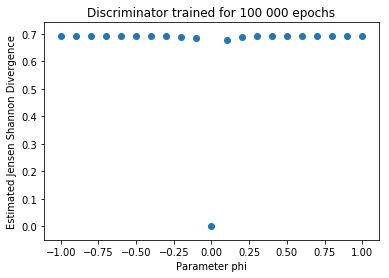

In [0]:
plt.scatter(phi,js_d)
plt.xlabel('Parameter phi')
plt.ylabel('Estimated Jensen Shannon Divergence')
plt.title('Discriminator trained for 100 000 epochs')
plt.savefig('/content/gdrive/My Drive/Q1_3_JSD.png')

In [0]:
def WD(Tx,Ty,GP,lam):
  return Tx.mean()-Ty.mean()-lam*GP

def GP_func(C,x,y):
  a=torch.FloatTensor(np.random.uniform(0, 1, (Tx.size()[0], 1))).to(device)
  z=a*x+(1-a)*y
  z= torch.autograd.Variable(z, requires_grad=True)
  Tz=C(z)
  gradients = torch.autograd.grad(Tz,z,grad_outputs= torch.ones(Tz.size()).to(device),create_graph=True, retain_graph=True, only_inputs=True) 
  return ((gradients[0].norm(2, dim=1)-1)**2).mean()
  

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
#         x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [0]:
phi=np.round(np.linspace(-1,1,21),2)
wd_d=np.zeros(phi.shape)
n_epochs = 50000
lr = 0.001
lam=10
for i in range(len(phi)):
  print('\nTraining discriminator for phi: ' + str(phi[i])+'\n')
  C = MLP().to(device)
  optimizer = torch.optim.SGD(C.parameters(), lr=lr)
  for epoch in range(n_epochs):
    optimizer.zero_grad()
    x = torch.FloatTensor(next(distribution1(0))).to(device)
    y = torch.FloatTensor(next(distribution1(phi[i]))).to(device)
    GP=GP_func(C,x,y)
    optimizer.zero_grad()
    Tx=C(x)
    Ty=C(y)
    loss=-WD(Tx,Ty,GP,lam)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
      print('phi : ' + str(0) + ', epoch: ' + str(epoch) +', loss: '+str(-loss.cpu().data.numpy()))
  print('phi : ' + str(0) + ', epoch: ' + str(epoch) +', loss: '+str(-loss.cpu().data.numpy()))
  wd_d[i]=-loss.cpu().data.numpy()
    
print('\nDone All training') 


Training discriminator for phi: -1.0

phi : 0, epoch: 0, loss: -8.234832
phi : 0, epoch: 5000, loss: 1.0244508
phi : 0, epoch: 10000, loss: 1.0240995
phi : 0, epoch: 15000, loss: 1.0252436
phi : 0, epoch: 20000, loss: 1.025073
phi : 0, epoch: 25000, loss: 1.0248928
phi : 0, epoch: 30000, loss: 1.0239294
phi : 0, epoch: 35000, loss: 1.025026
phi : 0, epoch: 40000, loss: 1.0250134
phi : 0, epoch: 45000, loss: 1.0251172
phi : 0, epoch: 49999, loss: 1.0250058

Training discriminator for phi: -0.9

phi : 0, epoch: 0, loss: -7.8236275
phi : 0, epoch: 5000, loss: 0.91857195
phi : 0, epoch: 10000, loss: 0.92039555
phi : 0, epoch: 15000, loss: 0.9209717
phi : 0, epoch: 20000, loss: 0.91923946
phi : 0, epoch: 25000, loss: 0.9204255
phi : 0, epoch: 30000, loss: 0.9199629
phi : 0, epoch: 35000, loss: 0.9200174
phi : 0, epoch: 40000, loss: 0.91998845
phi : 0, epoch: 45000, loss: 0.92019033
phi : 0, epoch: 49999, loss: 0.9202467

Training discriminator for phi: -0.8

phi : 0, epoch: 0, loss: -9.132

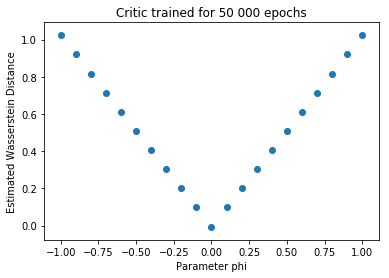

In [0]:
plt.scatter(phi,wd_d)
plt.xlabel('Parameter phi')
plt.ylabel('Estimated Wasserstein Distance')
plt.title('Critic trained for 50 000 epochs')
plt.savefig('/content/gdrive/My Drive/Q1_3_WD.png')

In [0]:
def JSD_2(Dx,Dy):
  return torch.mean(torch.log(Dy)) + torch.mean(torch.log(1 - Dx))

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
#         x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def name(self):
        return "MLP"

In [53]:
n_epochs = 100000
lr = 0.001
D = MLP().to(device)
optimizer = torch.optim.SGD(D.parameters(), lr=lr)
for epoch in range(n_epochs):
  x_d = torch.FloatTensor(next(distribution3(512))).to(device)
  y_g = torch.FloatTensor(next(distribution4(512))).to(device)
  optimizer.zero_grad()
  Dx=D(x_d)
  Dy=D(y_g)
  loss =-JSD_2(Dx,Dy)
  loss.backward()
  optimizer.step()
  if epoch % 5000 == 0:
    print('epoch: ' + str(epoch) +', loss: '+str(-loss.cpu().data.numpy()))
      
print('\nDone All training')

epoch: 0, loss: -1.4034219
epoch: 5000, loss: -1.2386776
epoch: 10000, loss: -1.2347502
epoch: 15000, loss: -1.1969967
epoch: 20000, loss: -1.1990709
epoch: 25000, loss: -1.1581612
epoch: 30000, loss: -1.219418
epoch: 35000, loss: -1.2296746
epoch: 40000, loss: -1.2162559
epoch: 45000, loss: -1.2243845
epoch: 50000, loss: -1.2795925
epoch: 55000, loss: -1.1617678
epoch: 60000, loss: -1.2140567
epoch: 65000, loss: -1.1686577
epoch: 70000, loss: -1.147807
epoch: 75000, loss: -1.1753765
epoch: 80000, loss: -1.2305504
epoch: 85000, loss: -1.172827
epoch: 90000, loss: -1.2000915
epoch: 95000, loss: -1.2368475

Done All training


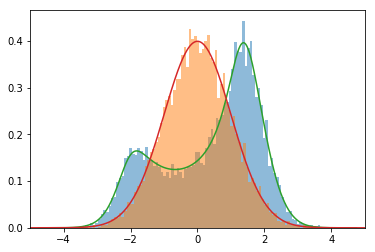

In [54]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))

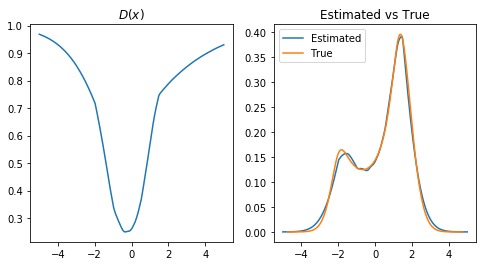

In [57]:
r = D(torch.FloatTensor(xx).to(device).unsqueeze(dim=1)).squeeze().cpu().data.numpy() # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

# estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
estimate=N(xx)*(r/(1-r))
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')

plt.savefig('/content/gdrive/My Drive/Q1_4_JSD.png')